In [216]:
import torch
import torch.nn as nn
from torch.nn import functional as fn
from torch.autograd import Variable
import matplotlib
import torch.nn.functional as F 
import numpy as np
import pickle

import matplotlib.pyplot as plt

In [217]:
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())


__Python VERSION: 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 18:21:58) 
[GCC 7.2.0]
__pyTorch VERSION: 0.4.0
__CUDA VERSION
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2015 NVIDIA Corporation
Built on Tue_Aug_11_14:27:32_CDT_2015
Cuda compilation tools, release 7.5, V7.5.17
__CUDNN VERSION: 7102
__Number CUDA Devices: 1
__Devices
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


In [218]:
train_xyz = []

with open('training/8v/data.pickle', 'rb') as f:
    data = pickle.load(f)

for i in range(len(data)):
    obj = np.asarray(data[i])
    #print("obj: ", obj)
    nv = 8
    dim = 36
    #print(obj.shape)
    train_xyz.append((obj))
    #print(train_xyz)
train_xyz = torch.Tensor(train_xyz)
train_xyz.shape  

torch.Size([10000, 3, 36])

In [219]:
train_xy = []

with open('training/8v/data.pickle', 'rb') as f:
    data = pickle.load(f)
    
for i in range(len(data)):
    obj = np.asarray(data[i])
    obj[2,0:8]=np.random.rand(8)
    train_xy.append(obj)
    #print(train_xyz)
train_xy = torch.Tensor(train_xy)
train_xy.shape        

torch.Size([10000, 3, 36])

In [220]:
# new version
import torch.nn.functional as F 

from functools import reduce
def num_edges(n):
    return int(n*(n-1)/2)

class DepthEstNet(nn.Module):    
    def __init__(self, vertices, nonlinearity = fn.tanh, additional_hidden_wide=0):
        super(DepthEstNet, self).__init__()
        self.vertices = vertices
        input_dim = vertices * 3
        self.edges = int(num_edges(vertices))
        edge_dim = self.edges * 3
        edges = self.edges
        self.conv_edge_vec = nn.ModuleList()
        self.conv_edge_num = vertices-1
        
        self.fc0 = nn.Linear(vertices, vertices)
        #self.conv_edge_vec.append(fc0)
        
#torch.nn.Conv1d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True)

        for i in range(1,vertices):
            m = nn.Conv1d(3, 3, 2, stride=1, dilation=i)
            m.weight = torch.nn.Parameter(torch.from_numpy(np.array(
            [[[1, -1],
             [0, 0],
             [0, 0]],
    
            [[0, 0],
             [1,-1],
             [0,0]],

            [[0,  0],
             [0, 0],
             [1, -1]]], dtype=np.float32)))
            m.bias = torch.nn.Parameter(torch.from_numpy(np.array([0,0,0], dtype=np.float32)))
            m.requires_grad = False
            self.conv_edge_vec.append(m)
        
#torch.nn.ConvTranspose1d(in_channels, out_channels, kernel_size, stride=1, padding=0, output_padding=0, 
#groups=1, bias=True, dilation=1)
        
        self.deconv_edge_vec = nn.ModuleList()
        self.deconv_edge_num = vertices-1
        for i in range(1,vertices):
            m = nn.Conv1d(3, 3, 2, stride=1, dilation=vertices-i)
            m.requires_grad = True
            self.deconv_edge_vec.append(m)        
        
        
        self.reverse_learn_params = nn.ModuleList()
        fc1 = nn.Linear(edges, edges*10)
        self.reverse_learn_params.append(fc1)
        fc2 = nn.Linear(edges*10, edges*20)
        self.reverse_learn_params.append(fc2)
        fc3 = nn.Linear(edges*20, vertices*20)
        self.reverse_learn_params.append(fc3)        
        fc4 = nn.Linear(vertices*20, vertices*10)
        self.reverse_learn_params.append(fc4)
        fc5 = nn.Linear(vertices*10, vertices)
        self.reverse_learn_params.append(fc5)
        
        self.layernorm = nn.LayerNorm(edges)
        self.nonlinearity = nonlinearity
        self.cos = nn.CosineSimilarity(dim=0, eps=1e-6)


    def forward(self, x, extract_x=False, extract_y=False, extract_z=False):
        n,d,t = x.size()
        x,conn = torch.Tensor.split(x,[self.vertices,t-self.vertices],dim=2)
        
        
        for i in range(self.conv_edge_num):
            y = self.conv_edge_vec[i](x)
            if (i==0):
                output = y
            else:
                output = torch.cat((output,y), dim=2)
   

        x_vec =  output[:,0,:] 

        temp = (self.reverse_learn_params[0](x_vec))
        temp = (self.reverse_learn_params[1](temp))
        temp = (self.reverse_learn_params[2](temp))
        temp = (self.reverse_learn_params[3](temp))
        vertexs_recovered = (self.reverse_learn_params[4](temp))
        
        
        if (extract_x):
            vec = output[:,0,:] #y[i,0,:]
            print("x output vec:", vec)
            temp = (self.reverse_learn_params[0](vec))
            temp = (self.reverse_learn_params[1](temp))
            temp = (self.reverse_learn_params[2](temp))
            temp = (self.reverse_learn_params[3](temp))
            vertexs_recovered = (self.reverse_learn_params[4](temp))
            return vertexs_recovered        
        
        if (extract_y):
            vec = output[:,1,:] #y[i,0,:]
            print("y output vec:", vec)
            temp = (self.reverse_learn_params[0](vec))
            temp = (self.reverse_learn_params[1](temp))
            temp = (self.reverse_learn_params[2](temp))
            temp = (self.reverse_learn_params[3](temp))
            vertexs_recovered = (self.reverse_learn_params[4](temp))
            return vertexs_recovered          
            
        if (extract_z):
            vec = output[:,2,:] #y[i,0,:]
            print("z output vec:", vec)
            temp = (self.reverse_learn_params[0](vec))
            temp = (self.reverse_learn_params[1](temp))
            temp = (self.reverse_learn_params[2](temp))
            temp = (self.reverse_learn_params[3](temp))
            vertexs_recovered = (self.reverse_learn_params[4](temp))
            return vertexs_recovered  
                

        return vertexs_recovered

In [221]:
#cuboid object

data = [[
         [0.60555981397628784, 1.019606590270996, 0.9311475157737732], 
         [0.7988362312316895, 0.14085637032985687, 1.1584558486938477], 
         [0.83646029531955719, 0.9592991471290588, 1.0384680032730103], 
         [1.040856385231018, 0.20116375386714935, 0.8111595511436462]]]

obj = np.asarray(data,dtype=np.float32)
obj.shape
nv = obj.shape[1]
obj = obj.T.reshape(1,3,nv)
obj = torch.tensor(obj)

print(type(obj))
print(obj.shape)

conn = torch.from_numpy(np.asarray([[[1,1,1,0,0,1],[1,1,1,0,0,1],[1,1,1,0,0,1]]],dtype=np.float32))

print(type(conn))
print(conn.shape)

input =  torch.cat((obj,conn), dim=2)

print(input)

<class 'torch.Tensor'>
torch.Size([1, 3, 4])
<class 'torch.Tensor'>
torch.Size([1, 3, 6])
tensor([[[ 0.6056,  0.7988,  0.8365,  1.0409,  1.0000,  1.0000,  1.0000,
           0.0000,  0.0000,  1.0000],
         [ 1.0196,  0.1409,  0.9593,  0.2012,  1.0000,  1.0000,  1.0000,
           0.0000,  0.0000,  1.0000],
         [ 0.9311,  1.1585,  1.0385,  0.8112,  1.0000,  1.0000,  1.0000,
           0.0000,  0.0000,  1.0000]]])


In [222]:
model = DepthEstNet(nv, nonlinearity=fn.sigmoid, additional_hidden_wide=1)
criterion = nn.L1Loss()

#print(model)
#print(list(model.parameters())[:])
model.forward(torch.Tensor(input))

tensor([[ 0.1615,  0.0117, -0.0140, -0.0878]])

In [223]:
model = DepthEstNet(8, nonlinearity=fn.relu, additional_hidden_wide=1)
criterion = nn.MSELoss()
print(model)

DepthEstNet(
  (conv_edge_vec): ModuleList(
    (0): Conv1d(3, 3, kernel_size=(2,), stride=(1,))
    (1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(2,))
    (2): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(3,))
    (3): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(4,))
    (4): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(5,))
    (5): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(6,))
    (6): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(7,))
  )
  (fc0): Linear(in_features=8, out_features=8, bias=True)
  (deconv_edge_vec): ModuleList(
    (0): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(7,))
    (1): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(6,))
    (2): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(5,))
    (3): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(4,))
    (4): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilation=(3,))
    (5): Conv1d(3, 3, kernel_size=(2,), stride=(1,), dilatio

In [224]:
train_xyz[1002,:,:]

tensor([[ 0.5916, -0.3119, -0.7628,  0.8529,  0.7653, -0.1382, -0.5892,
          1.0265,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.1043, -0.0550, -0.1345,  0.1504, -0.8805, -1.0398, -1.1193,
         -0.8344,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.7994,  0.9485, -0.6324, -0.5000,  0.7994,  0.9485, -0.6324,
         -0.5000,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,

In [225]:
train_xy[1002,:,:]

tensor([[ 0.5916, -0.3119, -0.7628,  0.8529,  0.7653, -0.1382, -0.5892,
          1.0265,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.1043, -0.0550, -0.1345,  0.1504, -0.8805, -1.0398, -1.1193,
         -0.8344,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.9954,  0.9832,  0.8497,  0.2002,  0.5841,  0.3266,  0.6127,
          0.8479,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,

In [226]:
import torch.utils.data
dataset = torch.utils.data.TensorDataset(train_xy[:,:,:], train_xyz[:,:,:])
loader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=True)

In [227]:
#print(list(model.parameters())[:])

cuda:0


/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


network loss ->  tensor(1.00000e-03 *
       3.2706, device='cuda:0')
network loss ->  tensor(1.00000e-03 *
       2.7236, device='cuda:0')
network loss ->  tensor(1.00000e-03 *
       1.9072, device='cuda:0')
network loss ->  tensor(1.00000e-04 *
       2.5014, device='cuda:0')
network loss ->  tensor(1.00000e-05 *
       3.5159, device='cuda:0')
network loss ->  tensor(1.00000e-05 *
       6.1034, device='cuda:0')
network loss ->  tensor(1.00000e-06 *
       9.7440, device='cuda:0')
network loss ->  tensor(1.00000e-05 *
       2.9101, device='cuda:0')
network loss ->  tensor(1.00000e-06 *
       7.3862, device='cuda:0')
network loss ->  tensor(1.00000e-05 *
       1.7662, device='cuda:0')
network loss ->  tensor(1.00000e-05 *
       7.3792, device='cuda:0')
network loss ->  tensor(1.00000e-07 *
       4.2917, device='cuda:0')
network loss ->  tensor(1.00000e-07 *
       8.1951, device='cuda:0')
network loss ->  tensor(1.00000e-07 *
       2.8480, device='cuda:0')
network loss ->  ten

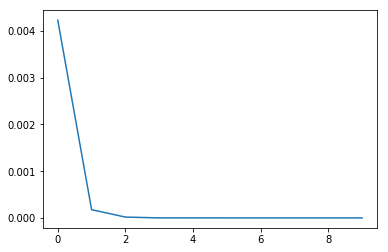

In [228]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assume that we are on a CUDA machine, then this should print a CUDA device:
print(device)
model.to(device)

lr, epochs, batch_size = 1e-1 , 10 , 10
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
i = 0
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        i =  i+1
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        output = model.forward(local_xy, extract_z=False)
        output = output.to(device)
        #print(output)
        loss = criterion(output, local_xy[:,0,0:8])
        #print(local_xy, local_xyz)
        if (i%500 == 0): print("network loss -> ", loss)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

In [229]:
orig_obj = [[ 0.5916, -0.3119, -0.7628,  0.8529,  0.7653, -0.1382, -0.5892,
          1.0265 ],
        [ 0.1043, -0.0550, -0.1345,  0.1504, -0.8805, -1.0398, -1.1193,
         -0.8344 ],
        [0.7994,  0.9485, -0.6324, -0.5000,  0.7994,  0.9485, -0.6324,
         -0.5000 ]]

In [230]:
obj = [[[ 0.5916, -0.3119, -0.7628,  0.8529,  0.7653, -0.1382, -0.5892,
          1.0265,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.1043, -0.0550, -0.1345,  0.1504, -0.8805, -1.0398, -1.1193,
         -0.8344,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000],
        [ 0.7994,  0.9485, -0.6324, -0.5000,  0.7994,  0.9485, -0.6324,
         -0.5000,  1.0000,  1.0000,  1.0000,  0.0000,  1.0000,  1.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  1.0000,  1.0000,
          1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000]]]

model.forward(torch.Tensor(obj).to(device))


tensor([[ 0.5910, -0.3114, -0.7625,  0.8529,  0.7644, -0.1374, -0.5889,
          1.0264]], device='cuda:0')

In [231]:
model.forward(torch.Tensor(obj).to(device), extract_x=True)


x output vec: tensor([[ 1.0034,  0.4354, -1.5519,  0.2613,  1.0388,  0.4709, -1.5165,
          1.3897, -1.0136, -1.3874,  1.1311,  1.4882, -0.9150,  0.0144,
         -0.8885, -0.5738,  1.6435,  0.1353, -0.3153, -0.2329, -0.2003,
         -0.3456,  0.6877,  0.2483, -1.8225,  1.1521, -1.3696, -0.2320]], device='cuda:0')


tensor([[ 0.5910, -0.3114, -0.7625,  0.8529,  0.7644, -0.1374, -0.5889,
          1.0264]], device='cuda:0')

In [232]:
model.forward(torch.Tensor(obj).to(device), extract_y=True)


y output vec: tensor([[ 0.1593,  0.0795, -0.2849,  1.0309,  0.1593,  0.0795, -0.2849,
          0.2388, -0.2054,  0.7460,  1.1902,  0.2388, -0.2054, -0.0461,
          0.8255,  0.9053,  1.2697, -0.0461,  0.9848,  0.9848,  0.9848,
          0.9848,  1.1441,  1.0643,  0.6999,  1.2236,  0.7794,  0.9387]], device='cuda:0')


tensor([[ 0.1490,  0.0282, -0.0404,  0.3209,  0.2292, -0.0217,  0.0871,
          0.2998]], device='cuda:0')

In [233]:
model.forward(torch.Tensor(obj).to(device), extract_z=True)


z output vec: tensor([[-0.1491,  1.5809, -0.1324, -1.2994, -0.1491,  1.5809, -0.1324,
          1.4318,  1.4485, -1.4318, -1.4485,  1.4318,  1.4485,  1.2994,
          0.1491, -1.5809,  0.1324,  1.2994,  0.0000,  0.0000,  0.0000,
          0.0000, -0.1491,  1.5809, -0.1324,  1.4318,  1.4485,  1.2994]], device='cuda:0')


tensor([[ 1.7258,  1.9356,  0.3867,  0.6655,  1.8534,  2.0136,  0.5846,
          0.7747]], device='cuda:0')

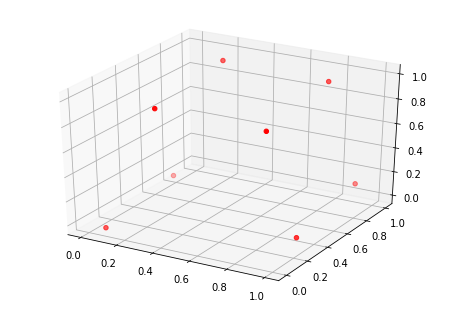

In [196]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
x = [ 0.5916, -0.3119, -0.7628,  0.8529,  0.7653, -0.1382, -0.5892,
          1.0265 ]
y =  [0.1043, -0.0550, -0.1345,  0.1504, -0.8805, -1.0398, -1.1193,
         -0.8344 ]
z =  [0.7994,  0.9485, -0.6324, -0.5000,  0.7994,  0.9485, -0.6324,
         -0.5000]
x=[(i-min(x))/(max(x)-min(x)) for i in x]
y=[(i-min(y))/(max(y)-min(y)) for i in y]
z=[(i-min(z))/(max(z)-min(z)) for i in z]

verts = [list(zip(x, y,z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')
plt.show()

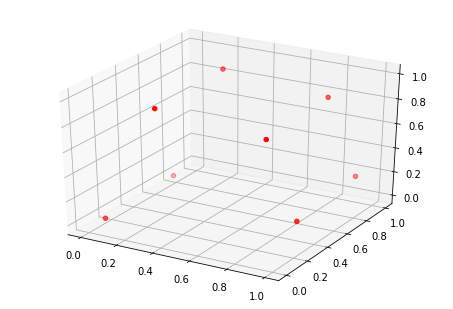

In [214]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
x = [ 0.5916, -0.3119, -0.7628,  0.8529,  0.7653, -0.1382, -0.5892,
          1.0265 ]
y =  [0.1043, -0.0550, -0.1345,  0.1504, -0.8805, -1.0398, -1.1193,
         -0.8344 ]
z =  [ 1.6900,  1.9499,  0.3653,  0.6160,  1.7977,  2.0657,  0.5010,
          0.7358]
x=[(i-min(x))/(max(x)-min(x)) for i in x]
y=[(i-min(y))/(max(y)-min(y)) for i in y]
z=[(i-min(z))/(max(z)-min(z)) for i in z]

verts = [list(zip(x, y,z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')
plt.show()

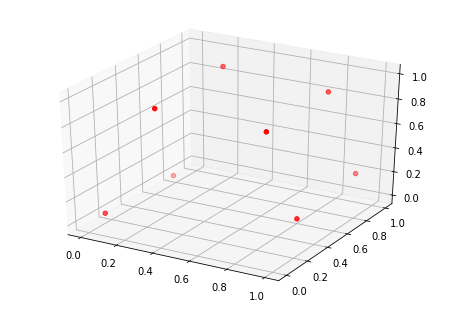

In [234]:
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.pyplot as plt
fig = plt.figure()
ax = Axes3D(fig)
x = [ 0.5916, -0.3119, -0.7628,  0.8529,  0.7653, -0.1382, -0.5892,
          1.0265 ]
y =  [0.1043, -0.0550, -0.1345,  0.1504, -0.8805, -1.0398, -1.1193,
         -0.8344 ]
z =  [ 1.7258,  1.9356,  0.3867,  0.6655,  1.8534,  2.0136,  0.5846,
          0.7747]
x=[(i-min(x))/(max(x)-min(x)) for i in x]
y=[(i-min(y))/(max(y)-min(y)) for i in y]
z=[(i-min(z))/(max(z)-min(z)) for i in z]

verts = [list(zip(x, y,z))]
#ax.add_collection3d(Poly3DCollection(verts))
ax.scatter(x, y, z, c='r', marker='o')
plt.show()

/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


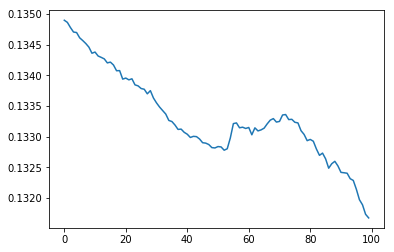

In [191]:
lr, epochs, batch_size = 1e-1 , 100 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        output = model.forward(local_xy, extract_z=False)
        output = output.to(device)
        #print(output)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        #print(local_xy, local_xyz)
        #print("loss -> ", loss, "loss's grad function -> ", loss.grad_fn)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      

/home/mishra/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: UserWarning: invalid index of a 0-dim tensor. This will be an error in PyTorch 0.5. Use tensor.item() to convert a 0-dim tensor to a Python number


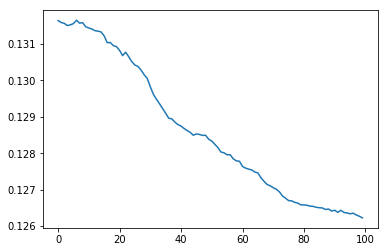

In [196]:
lr, epochs, batch_size = 1e-1 , 100 , 1
optimizer = torch.optim.SGD(model.parameters(), lr = lr )
accum=[]
for k in range(epochs):
    localaccum = []
    for xy, xyz in iter(loader):
        local_xy = Variable(xy)
        #print(local_xy)
        local_xyz = Variable(xyz)
        local_xy = local_xy.to(device)
        output = model.forward(local_xy, extract_z=False)
        output = output.to(device)
        #print(output)
        loss = criterion(output, torch.Tensor.new_zeros(output, output.size()))
        #print(local_xy, local_xyz)
        #print("loss -> ", loss, "loss's grad function -> ", loss.grad_fn)
        model.zero_grad()
        loss.backward()
        optimizer.step()
        localaccum.append(loss.data[0])
    accum.append(np.mean(localaccum))
plt.plot(accum);                      